<h1 style="color:green; font-family: 'Helvetica Neue', sans-serif; font-size:40px; text-align: center; font-weight:bold; font-style:Bold">OryzaCare</h1>

# Domain Analysis

Rice stands as a pivotal staple worldwide, feeding over half the global population. However, rice plants face vulnerability to several diseases, posing substantial threats to yield and quality. Major afflictions include bacterial leaf blight, brown spot, and leaf smut.

<font color='tomato'>Bacterial leaf blight</font>, triggered by Xanthomonas oryzae pv. oryzae, induces severe harm with symptoms like water-soaked lesions evolving into dry, brown patches. In extreme cases, wilting and plant death occur, significantly reducing crop yield.

<font color='tomato'>Brown spot</font>, caused by Cochliobolus miyabeanus, is another impactful disease, marked by small brown-spotted leaves with a yellow halo. Severe instances lead to leaf withering and panicle impact, diminishing grain quality and yield.

<font color='tomato'>Leaf smut</font>, caused by Entyloma oryzae, is less common. Its symptoms involve small, reddish-brown spots turning black, producing powdery spores. Although not a major yield threat, leaf smut affects grain quality by reducing weight and size.

Effective disease management, including crop rotation, resistant cultivars, fungicide application, and cultural practices, is vital. Machine learning, leveraging large plant image datasets and advanced algorithms, emerges as a promising tool for accurate disease diagnosis and classification. This innovation holds the potential to enhance disease management, mitigating the impact on crop production.

# Importing Library

In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2023-12-13 18:13:28.952621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 18:13:29.139296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 18:13:29.139349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 18:13:29.156159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 18:13:29.212883: I tensorflow/core/platform/cpu_feature_guar

we are currently using tensorflow version 2.15.0


# Setting Up An Envrironment

In [2]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

# Uploading Image Dataset

In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='/mnt/d/College/Semester 7/Assignment/Capstone/rice_leaf_diseases', #D:/College/Semester 7/Assignment/Capstone/rice_leaf_diseases
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 120 files belonging to 3 classes.


2023-12-13 18:13:32.448951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 18:13:32.548716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 18:13:32.548765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 18:13:32.550608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 18:13:32.550663: I external/local_xla/xla/stream_executor

In [4]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

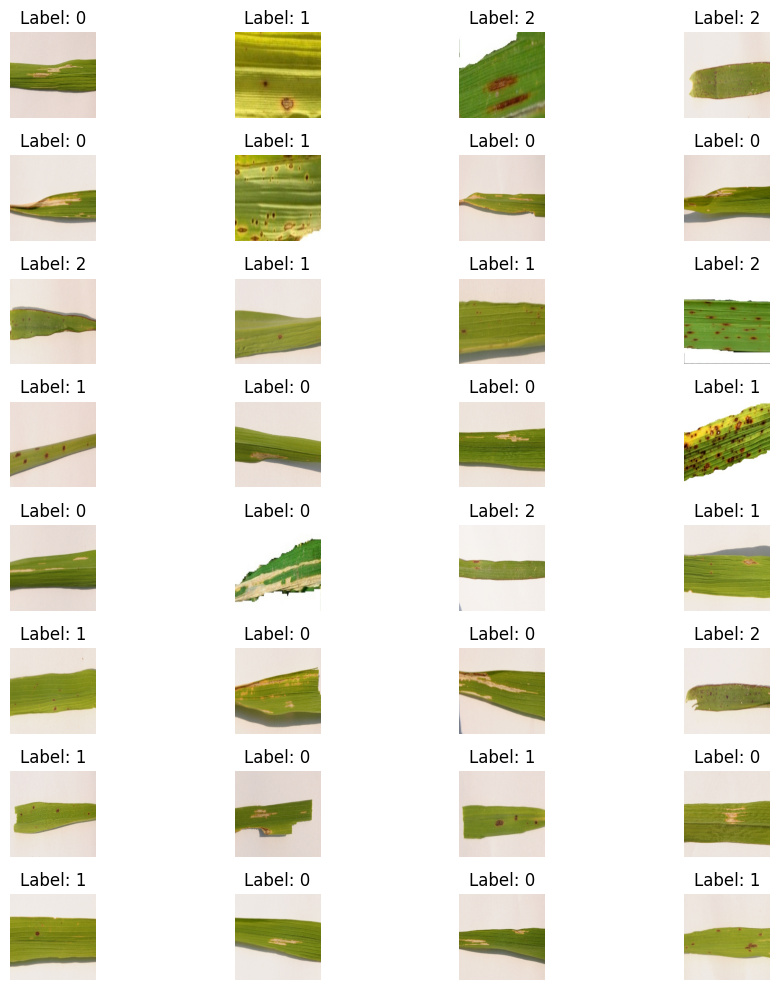

In [6]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

# Data Preprocessing

In [7]:
X=[]
y=[]

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [8]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Normalisation

In [10]:
X_train = X_train/255
X_test = X_test/255

In [11]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (90, 224, 224, 3)
shape of y_train: (90,)
shape of X_test_scaled: (30, 224, 224, 3)
shape of y_test: (30,)


# Encoding

In [12]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# Data Augmentation

Data augmentation is a pivotal technique employed to augment the size and diversity of a dataset by applying diverse transformations to existing data. Widely utilized in computer vision and image processing tasks like object recognition and classification, this technique plays a vital role in enhancing machine learning models' generalization ability and mitigating overfitting.

In the realm of our rice leaf disease image classification project, data augmentation emerges as a critical factor for improving model performance and robustness. By generating new images through rotations, flips, zooms, and other transformations, we effectively expand the dataset's diversity. This equips our model with a broader range of examples, fostering improved classification accuracy and resilience to real-world data variations.

Given its significance, exploring varied techniques and approaches for effective implementation will be a focal point in our project.

In [19]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

## Xception

Xception is a deep neural network architecture proposed by Google researchers in 2016. It is an extension of the Inception architecture that replaces the standard Inception modules with depthwise separable convolutions, which are computationally efficient and lead to improved performance. Xception has achieved state-of-the-art results on various computer vision tasks and is commonly used in transfer learning applications.

In [35]:
xception_base = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
  if layer.name=='add_8':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#building fully connected layers
xception_model=Sequential()

xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(3, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Without Augmentation

In [37]:
#training model
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history=xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[stopper, checkpointer_xception]
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 6.3982 - accuracy: 0.3667
Epoch 1: val_loss improved from inf to 8.49125, saving model to xception.weights.best.hdf5
3/3 [==============================] - 20s 4s/step - loss: 6.3982 - accuracy: 0.3667 - val_loss: 8.4913 - val_accuracy: 0.5333
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.5444
Epoch 2: val_loss improved from 8.49125 to 4.81384, saving model to xception.weights.best.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.9380 - accuracy: 0.5444 - val_loss: 4.8138 - val_accuracy: 0.3000
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.4889
Epoch 3: val_loss did not improve from 4.81384
3/3 [==============================] - 0s 150ms/step - loss: 0.8676 - accuracy: 0.4889 - val_loss: 9.0489 - val_accuracy: 0.2333
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.5000
Epoch 4: val_loss

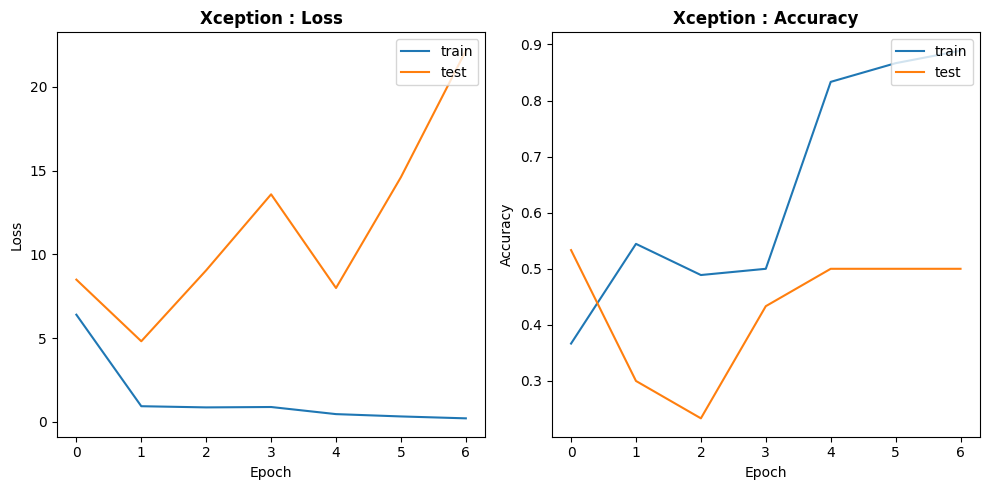

In [38]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'], 
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'], 
                 val_loss=xception_history.history['val_loss'])

#### With Augmentation

In [39]:
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history_aug=xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[stopper, checkpointer_xception_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.8276
Epoch 1: val_loss improved from inf to 24.45103, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 4s 2s/step - loss: 0.4109 - accuracy: 0.8276 - val_loss: 24.4510 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7931
Epoch 2: val_loss improved from 24.45103 to 23.72331, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 3s 3s/step - loss: 0.4581 - accuracy: 0.7931 - val_loss: 23.7233 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8594
Epoch 3: val_loss improved from 23.72331 to 16.87618, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 3s 2s/step - loss: 0.3844 - accuracy: 0.8594 - val_loss: 16.8762 - val_accuracy: 0.5333
Epoch 4/30
2/2 [=============================

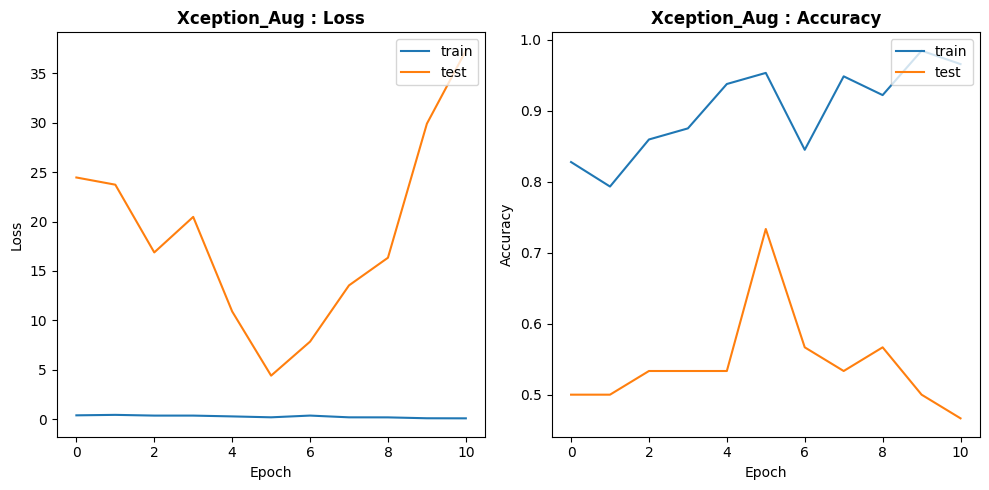

In [40]:
plot_performance(model_name='Xception_Aug',
                 acc=xception_history_aug.history['accuracy'], 
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'], 
                 val_loss=xception_history_aug.history['val_loss'])

In [41]:
xception_model.load_weights('xception_aug.weights.best.hdf5')

# Visualising Prediction


In [46]:
# get predictions on the test set
y_hat = xception_model.predict(X_test)

# define text labels
labels = data_ds.class_names

1/1 [==============================] - 1s 502ms/step


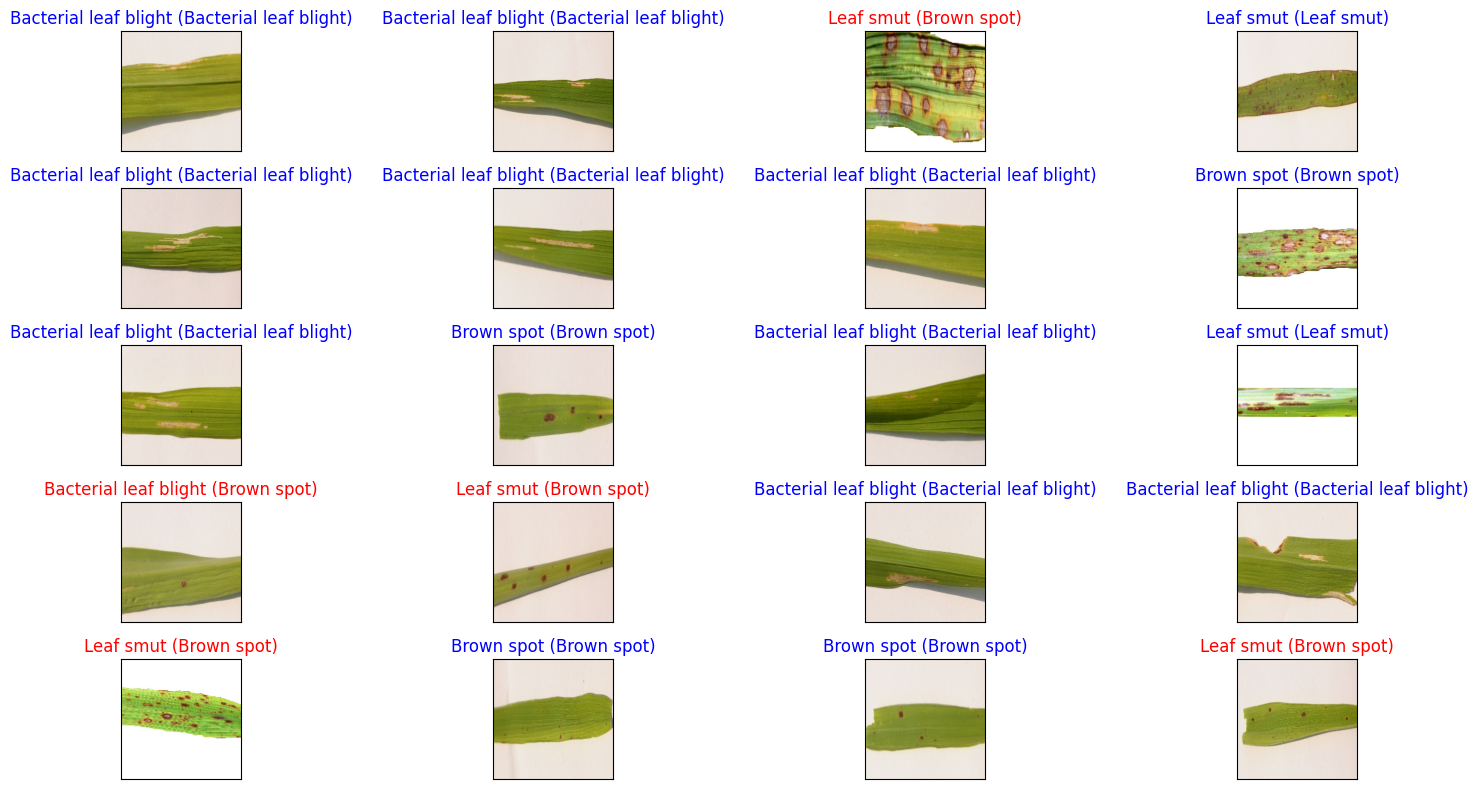

In [47]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()